# Image Segmentation - 7150, 7128

We intend to perform image segmentation. Image segmentation means that we can group similar pixels together and give these grouped pixels the same label. 

The grouping problem is a clustering problem. We want to study the use of K-means on the Berkeley Segmentation Benchmark. 

In [1]:
# import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
import scipy.io as io
from random import uniform
from sklearn.metrics.pairwise import euclidean_distances

## 1. Download the Dataset and Understand the Format (5 points)

## 2. Visualize the image and the G.T Segmentation (5 points)

In [2]:
img_path = 'dataset/BSR/BSDS500/data/images/test'
gt_path = 'dataset/BSR/BSDS500/data/groundTruth/test'

dataset = {}

# Load images
dataset['imgs'] = np.empty((0, 321, 481, 3), int)
for dirname, _, filenames in os.walk(img_path):
    filenames.sort()
    for filename in filenames:
        temp = os.path.join(dirname, filename)
        img_tmp = cv2.imread(temp)
        img_rgb = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
        if img_rgb.shape[0] != 321:
            img_rgb = cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
        dataset['imgs'] = np.append(dataset['imgs'], np.expand_dims(img_rgb, 0), axis=0)
        # dataset['imgs'].append(img_rgb)
            
# Load ground truths         
dataset['gt'] = []
for dirname, _, filenames in os.walk(gt_path):
    filenames.sort()
    for filename in filenames:
        temp = os.path.join(dirname, filename)
        file = io.loadmat(temp)
        map_list = []
        edges = file['groundTruth'][0][0][0][0][1]
        second_dim = file['groundTruth'].shape[1]
        for i in range(second_dim):
            mapp = file['groundTruth'][0][i][0][0][0]
            map_list.append(mapp)
        edges_255 = edges * 255
        final = [edges_255, map_list]
        #dataset['gt'] = np.append(dataset['gt'], final)
        dataset['gt'].append(final)

In [3]:
for path in dataset:
    dataset[path] = np.array(dataset[path])
    print("Shape of", path, "is equal", dataset[path].shape)

Shape of imgs is equal (200, 321, 481, 3)
Shape of gt is equal (200, 2)


/tmp/ipykernel_2687439/3465898119.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset[path] = np.array(dataset[path])


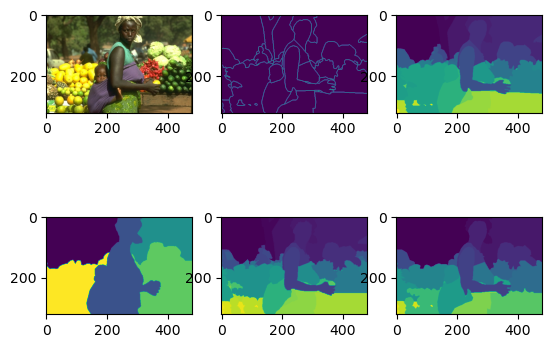

In [4]:
import random
def visualize_random():
    n = random.randint(0, 200)
    fig, axes = plt.subplots(2, 3)
    axes[0, 0].imshow(dataset["imgs"][n])
    axes[0, 1].imshow(dataset["gt"][n][0])
    axes[0, 2].imshow(dataset["gt"][n][1][0])
    axes[1, 0].imshow(dataset["gt"][n][1][1])
    axes[1, 1].imshow(dataset["gt"][n][1][2])
    axes[1, 2].imshow(dataset["gt"][n][1][3])
    
    plt.show()
    
visualize_random()

In [5]:
def visualize_cluster(n, assignment):
    fig, axes = plt.subplots(2, 3)
    axes[0, 0].imshow(dataset["imgs"][n])
    axes[0, 1].imshow(assignment)
    axes[0, 2].imshow(dataset["gt"][n][1][0])
#     axes[1, 0].imshow(dataset["gt"][n][1][1])
#     axes[1, 1].imshow(dataset["gt"][n][1][2])
#     axes[1, 2].imshow(dataset["gt"][n][1][3])
    
    plt.show()


In [6]:
dataset['imgs'][0].shape

(321, 481, 3)

## 3. Segmentation using K-means (15 points)

We will change the K of the K-means algorithm between {3,5,7,9,11}
clusters. We will produce different segmentations and save them as
colored images. Every color represents a certain group (cluster) of
pixels.

In [122]:
class KMeans:
    
    def __init__(self, n_clusters=3, max_iter=75, distribution='uniform'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distribution = distribution

    def fit(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
        '''
        # Reshape x to be of shape [(hxw) x 3]
        X = np.reshape(data, (-1, 3))
        # Get random initial centroids using uniform distribution
        self.old_centroids = [np.array([1000, 1000, 1000])+i for i in range(self.n_clusters)]
        if self.distribution == 'uniform':
            min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
            self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
            self.centroids = np.stack(self.centroids)
        elif self.distribution == 'normal':
            self.centroids = np.random.randn(self.n_clusters, X.shape[1])
        elif self.distribution == 'random':
            self.centroids = [random.choice(X) for _ in range(self.n_clusters)]
            
        t = 0
        # Start loop
        while not np.allclose(self.old_centroids, self.centroids) and t < self.max_iter:
            # Step 1: Cluster Assignment
            assignment = np.zeros((X.shape[0], 1))
            for i, x in enumerate(X): 
                dists = [np.linalg.norm(x - c) for c in self.centroids]
                idx = np.argmin(dists)
                assignment[i] = idx
                
            self.old_centroids = self.centroids.copy()
            # Step 2: Centroid Update
            for i in range(self.n_clusters):
                assigned = X[np.where(assignment==i)]
                self.centroids[i] = np.mean(assigned, axis=0)
                
            # Error checking if a centroid has no points
#             for i, centroid in enumerate(self.centroids):
#                 if np.isnan(centroid).any():
#                     self.centroids[i] = self.old_centroids[i]
            
            t+=1
        print("# of iterations", t)
        
    def predict(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
                
            Return values:
                clustered_data: numpy array of shape [ h x w x 1 ]
        '''
        X = np.reshape(data, (-1, 3))
        assignment = np.zeros((X.shape[0], 1))
        for i, x in enumerate(X): 
            dists = [np.linalg.norm(x - c) for c in self.centroids]
            idx = np.argmin(dists)
            assignment[i] = idx
        assignment = np.reshape(assignment, (321, 481))
        return assignment

In [126]:
class KMeans2:
    
    def __init__(self, n_clusters=3, max_iter=75, distribution='uniform'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distribution = distribution

    def fit(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
        '''
        # Reshape x to be of shape [(hxw) x 3]
        X = np.reshape(data, (-1, 3))
        # Get random initial centroids using uniform distribution
        self.centroids = [random.choice(X) for _ in range(self.n_clusters)]
        old_centroids = [np.array([1000, 1000, 1000])+i for i in range(self.n_clusters)]
        t = 0
        # Start loop
        while np.allclose(old_centroids, self.centroids) is False and t < self.max_iter:
            print(self.centroids)
            # Step 1: Cluster Assignment
            assignment = np.zeros((X.shape[0], 1))
            for i, x in enumerate(X): 
                dists = [np.linalg.norm(x - c) for c in self.centroids]
                idx = np.argmin(dists)
                assignment[i, :] = idx
            old_centroids = self.centroids.copy()
            # Step 2: Centroid Update
            for i in range(self.n_clusters):
                assigned = X[np.where(assignment[:, 0]==i), :]
                self.centroids[i] = np.mean(assigned, axis=1)
            #Error checking if a centroid has no points
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = old_centroids[i]
            t+=1
        print("# of iterations", t)
        
    def predict(self, data):
        '''
            Arguments:
                data: numpy array of shape [ h x w x 3 ]
                
            Return values:
                clustered_data: numpy array of shape [ h x w x 1 ]
        '''
        X = np.reshape(data, (-1, 3))
        assignment = np.zeros((X.shape[0], 1))
        for i, x in enumerate(X): 
            dists = [np.linalg.norm(x - c) for c in self.centroids]
            idx = np.argmin(dists)
            assignment[i, :] = idx
        assignment = np.reshape(assignment, (321, 481))
        return assignment

In [ ]:
kmeans = KMeans(5, 75)
kmeans.fit(dataset['imgs'][0])
indices = kmeans.predict(dataset['imgs'][0])

/home/nour.hesham/anaconda3/envs/qgis/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
visualize_cluster(0, indices)

In [ ]:
from sklearn.cluster import KMeans

Ks = [3, 5, 7, 9, 11]
results = {}
labels = {}
for k in Ks:
    results[k] = []
    labels[k] = []
    for i in range(50):
        image = dataset["imgs"][i]
        image = image.reshape((321*481, -1))
        kmeans = KMeans(n_clusters=k, random_state=0).fit(image[:,:])
        pic2show = kmeans.cluster_centers_[kmeans.labels_]
        pic2show = pic2show.reshape((321, 481, -1))
        pic2show = pic2show.astype(np.uint8)
        labels[k].append(kmeans.labels_)
        results[k].append(pic2show)


In [ ]:
def add_label(axe,title):
    axe.text(0.5, -0.3, title, size=12, ha="center", transform=axe.transAxes)

def visualize_results():

    n = random.randint(0, 50)

    fig, axes = plt.subplots(3, 2)
    fig.tight_layout()
    axes[0][0].imshow(dataset["imgs"][n])
    add_label(axes[0][0],"Original Picure")
    axes[0][1].imshow(results[3][n])
    add_label(axes[0][1],"at K = 3")
    axes[1][0].imshow(results[5][n])
    add_label(axes[1][0],"at K = 5")
    axes[1][1].imshow(results[7][n])
    add_label(axes[1][1],"at K = 7")
    axes[2][0].imshow(results[9][n])
    add_label(axes[2][0],"at K = 9")
    axes[2][1].imshow(results[11][n])
    add_label(axes[2][1],"at K = 11")
    plt.show()
    
visualize_results()
    

### Conditional Entropy and F-Measure

In [ ]:
from math import log10 as log

from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support



def conditional_entropy(cluster_labels, gt):
    
    gt_labels = gt.flatten() # 154401 x 1

    contingency_mat = contingency_matrix (gt_labels,cluster_labels)
    contingency_T = contingency_mat.T
    
    count_cluster = np.sum(contingency_T, axis =1)
    
    count_entropy = np.where(np.copy(contingency_T) == 0, 1, np.copy(contingency_T)) ## where log(1) = 0 && log(0) = -infinty
    entropy_mat = np.zeros((count_entropy.shape[0],1))
    
    for i in range(count_entropy.shape[0]):
        entropy_mat[i] = np.sum(-contingency_T[i]*np.log10(count_entropy[i]/np.sum(contingency_T[i]))) / np.sum(contingency_T[i]) ## H(T|Ci)
        entropy_mat[i] = count_cluster[i] * entropy_mat[i] ## segma i = 1 till number of clusters : counter per cluster * H(T|Ci)
   
    entropy = np.sum(entropy_mat)/ np.sum(count_cluster) ## final conditional entropy
    
    return entropy

def f_measure(img_labels,gt):
    gt_labels = gt.flatten() # 154401 x 1
    _, _, fscore, _ = precision_recall_fscore_support(gt_labels, img_labels)
#     print(fscore)
    return fscore
#     return f1_score(gt_labels, img_labels, average=None)
    


# for each K there is a corresponding conditional entropy value 
# where we are going to take the average of the conditional entropy 
# of the 50 images that we are testing.

 # for each k there exists 50 images where each image has 5 conditional entropy
conditional_entropies = {}
f_measures = {}
# k -> image index -> 5 (ground truth variations) -> conditional entropy
# (#_ofKs) 5 * (#_ofImages) 50 * (Without Edges) 4  

# for each k there exists 50 images where each image has an avg conditional entropy
# TLDR: avg of conditional_entropies for each image 
avg_conditional_entropies = {}
avg_fmeasures = {}
# (#_ofKs) 5 * (#_ofImages) 50

for k in labels.keys():
    # for each results[k] there exists 50 images
    k_image_avg_conditional_entropy = []
    k_image_conditional_entropy = {}
    
    k_image_avg_fmeasure = []
    k_image_fmeasure = {}
    
    for j, img in enumerate(labels[k]):
        m_conditional_entropies = []
        m_fmeasures = []
        # for each image we want to calculate the conditional entropy 
        # and then using all of the available ground truth of size M (= 5)
        # and then taking the average of the conditional entropies 
        # resulted from the 5 versions of ground turths existing for each image
        
        image_avg_entropy = 0
        image_avg_fmeasure = 0
        
        # dataset['gt]' 
        # 0 -> edges
        # 1, 2, 3, 4 -> actual ground_truth
        for gt_v in [1,2,3,4]:
            image_entropy = conditional_entropy(img, dataset['gt'][j][gt_v])
            image_avg_entropy += image_entropy
            m_conditional_entropies.append(image_entropy)
            
            
            image_fmeasure = f_measure(img, dataset['gt'][j][gt_v])
            #TODO: F-Measure
#             image_avg_fmeasure += image_fmeasure
            image_avg_fmeasure += 0
            m_fmeasures.append(image_fmeasure)
            
            # for each gt version find the conditional entorpy
        image_avg_entropy /= 4  # len([1,2,3,4]) # finding avg
        image_avg_fmeasure /= 4
        
        k_image_conditional_entropy[j] = m_conditional_entropies
        k_image_avg_conditional_entropy.append(image_avg_entropy)
        
        k_image_fmeasure[j] = m_fmeasures
        k_image_avg_fmeasure.append(image_avg_fmeasure)
        
        
    conditional_entropies[k] = k_image_conditional_entropy
    avg_conditional_entropies[k] = k_image_avg_conditional_entropy
    
    f_measures[k] = k_image_fmeasure
    avg_fmeasures[k] = k_image_avg_fmeasure
            


In [ ]:
len(avg_conditional_entropies[11])

In [ ]:
len(conditional_entropies[11][0])

## 4. Big Picture (10 Points)

## 5. Extra